In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


import scipy.stats as stats 
from scipy.stats import chi2_contingency, boxcox

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm 

In [4]:
df = pd.read_csv('Maternal-risk-processed.csv')

# PREDICCIÓN DE RIESGO MATERNAL CON ALGORITMO KNN

### Detalles del modelo

Modelo de ML para la clasificación supervisada. Clasifica una muestra desconocida basándose en la mayoría de laws clases de sus vecinos más ceracanos en el espacio de características. Identifica los K vecinos más cercanos aplicando distancia euclidiana.

El valor de K (número de vecinos) es importante, pero no se conoce le valor que se ha de poner a priori. A menor tamaño, menor distancias a caclular y por tanto tarda menos en hacer las predicciones, por eso para este algoritmo es importante haberlo escalado previamente. Un K muy pequeño lleva a overfitting, un modelo ruidoso, y, un K muy grande suavizada demasiado la clasificación(underfitting).

### Separación de características y objetivo

La variable X tendra las característricas numéricas.

La variable Y tendrá las etiquetas de la columna RiskLevel.

In [7]:
x = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

## ENTRENAMIENTO DEL MODELO

In [10]:
#Separamos datos entre muestra de entrenamiento y muestra de test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101, stratify=y)

In [12]:
#Creamos y ajustamos el modelo
knn=KNeighborsClassifier(n_neighbors=1)
history=knn.fit(X_train, y_train)

#Hacemos predicciones
knnPreds = knn.predict(X_test)

**EVALUACIÓN DEL RENDIMIENTO**

In [15]:
print(f"\nK Nearest Neighbors k = 1\n")
print(confusion_matrix(y_test, knnPreds))
print("\n")
print(classification_report(y_test, knnPreds))


K Nearest Neighbors k = 1

[[54 13  3]
 [16  9  7]
 [ 7  7 20]]


              precision    recall  f1-score   support

           0       0.70      0.77      0.73        70
           1       0.31      0.28      0.30        32
           2       0.67      0.59      0.62        34

    accuracy                           0.61       136
   macro avg       0.56      0.55      0.55       136
weighted avg       0.60      0.61      0.60       136



Para K = 1, vemos que:

la clase 0 tiene un gran desempeño (recall de 0.71), y con una precision del 70%, es decir que hay algunos ejemplos clasificados como clase 1 que no lo son.
Clase 1 tiene un desempeño muy pobre, en todas las métricas, el algoritmo tiene dificultades para reconocer esta clase.
La clase 2 tiene la que mejor precisión, aunque el recall muestra que algunos casos de esta clase se pierden.

Una de las acciones que se nos ocurre ante este reusltado es ajustar K, también probar además de la distancia euclidiana, Manhattan o Minkowski.

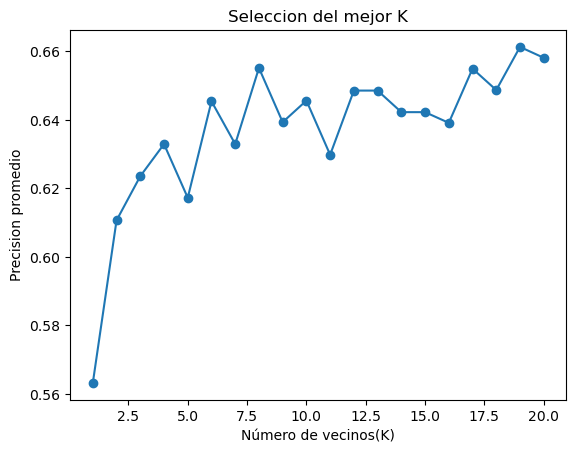

El mejor valor de K es: 19


In [18]:
from sklearn.model_selection import cross_val_score
valoresK = range(1,21) #valores de k a porbar
mean_scores = [] #lista para guardar la pprecisión promedio

for k in valoresK:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    mean_scores.append(np.mean(scores))

plt.plot(valoresK, mean_scores, marker = 'o')
plt.xlabel("Número de vecinos(K)")
plt.ylabel("Precision promedio")
plt.title("Seleccion del mejor K")
plt.show()

best_k = valoresK[np.argmax(mean_scores)]
print(f"El mejor valor de K es: {best_k}")

In [19]:
#Creamos y ajustamos el modelo
knn=KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, y_train)

#Hacemos predicciones
knnPreds = knn.predict(X_test)

In [22]:
print(f"\nK Nearest Neighbors k = 19\n")
print(confusion_matrix(y_test, knnPreds))
print("\n")
print(classification_report(y_test, knnPreds))


K Nearest Neighbors k = 19

[[67  3  0]
 [29  3  0]
 [17  6 11]]


              precision    recall  f1-score   support

           0       0.59      0.96      0.73        70
           1       0.25      0.09      0.14        32
           2       1.00      0.32      0.49        34

    accuracy                           0.60       136
   macro avg       0.61      0.46      0.45       136
weighted avg       0.61      0.60      0.53       136



Áún usando el mejor K, para identificar y clasificar la clase 1 sigue siendo muy pobre. Vamos a optimizar la búsqueda y selección de hiperparámetros de este algoritmo con GridSearch.

**Configuración de grid search e hiperparámetros:**

Configuración de hiperparámetros:
<ul>
    <li>Modelo base: <code>KNeigborsClassifier</code></li>
    <li>n_neigbors: ajusta el número de vecinos para probar de distintos tamaños.</li>
    <li>weights: <code>'uniform'</code> (todos los vecinos tienen la misma importancia) o <code>'distance'</code> (los vecinos más cercanos tienen más peso).</li>
    <li>metric: <code>'euclidean'</code> (distancia euclidiana), <code>'manhattan'</code> (distancia manhattan), <code>'minkowski'</code> (generalización entre euclidiana y manhattan).</li>
</ul>

Configuración de <code>GridSearch</code>:
<ul>
    <li>cv: divisiones entre las que realiza lavalidación cruzada.</li>
    <li>scoring: tipo de métrica a evaluar (preision, f1, recall, etc.)</li>
    <li>n_jobs: si es -1 usa todos ñps núcleos de la CPU.</li>
</ul>

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

param_grid = {
    'n_neighbors': [2, 3, 5, 7, 9, 12, 17, 20],         # Número de vecinos a probar
    'weights': ['uniform', 'distance'], # Ponderación de vecinos
    'metric': ['euclidean', 'manhattan', 'minkowski'] # Métricas de distancia
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

#Ajustamos el modelo
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:", grid_search.best_params_)
print("Precision en validación cruzada con los mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros encontrados: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Precision en validación cruzada con los mejores hiperparámetros: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


In [63]:
#Creamos y ajustamos el modelo
knn=KNeighborsClassifier(n_neighbors=9, metric='manhattan', weights='uniform')
knn.fit(X_train, y_train)

#Hacemos predicciones
knnPreds = knn.predict(X_test)

In [66]:
print(f"\nK Nearest Neighbors k = 19, weights=uniform, metric = manhattan\n")
print(confusion_matrix(y_test, knnPreds))
print("\n")
print(classification_report(y_test, knnPreds))


K Nearest Neighbors k = 19, weights=uniform, metric = manhattan

[[66  4  0]
 [25  4  3]
 [12  8 14]]


              precision    recall  f1-score   support

           0       0.64      0.94      0.76        70
           1       0.25      0.12      0.17        32
           2       0.82      0.41      0.55        34

    accuracy                           0.62       136
   macro avg       0.57      0.49      0.49       136
weighted avg       0.59      0.62      0.57       136



In [69]:
from sklearn.model_selection import cross_val_score

# Validación cruzada
scores = cross_val_score(knn, X_train, y_train, cv=5)

print("Cross-validation scores:", scores)
print(f"Mean CV Accuracy: {scores.mean():.2f}")

Cross-validation scores: [0.671875   0.65079365 0.61904762 0.65079365 0.71428571]
Mean CV Accuracy: 0.66


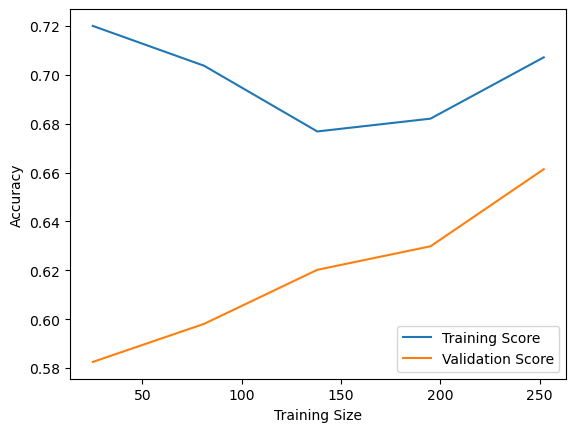

In [72]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=5)

# Calcular medias
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Graficar
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, test_mean, label="Validation Score")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**INTERPRETACIÓN**